## Nolan Roth
## Overview of the OceanParcels Module for Python
## Computational Physics

In [1]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
%matplotlib inline
from parcels import Field
from datetime import timedelta as delta
from IPython.display import Image
np.set_printoptions(threshold=np.nan)

## Computational Fluid Dynamics is Really Difficult,

and not many people have figured out how to do it. One method, though, to visualize--but not necessarily create--fluid flow data uses a module I found called:

## Parcels

http://oceanparcels.org/


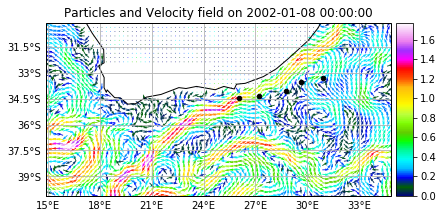

In [129]:
Image(filename='SouthAfrica.png',width=2000,height=2000)

What is it?

Parcels (Probably A Really Computationally Efficient Lagrangian Simulator), is a set of Python classes and methods to create customisable particle tracking simulations. The following cells walk through some of the uses of Parcels, and give examples of how to set up personalized vector fields.

This first example shows the foundation of what Parcels can do: it creates a vector field and allows you to visualize it.

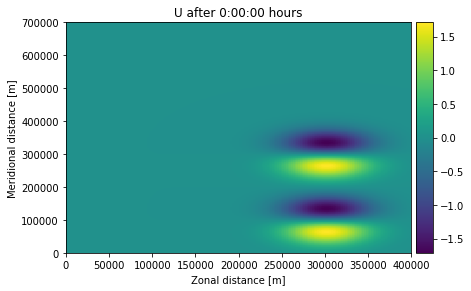

In [130]:
fieldset = FieldSet.from_parcels("MovingEddies_data/moving_eddies")
fieldset.U.show()

You can also create particles within that vector field and track their movements! Let's start by creating two particles within our moving eddy.

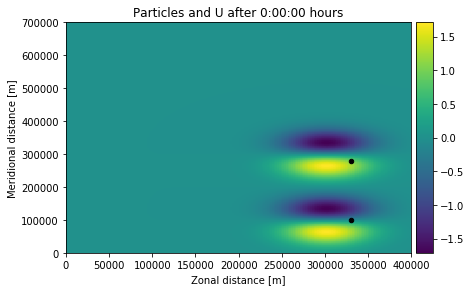

In [131]:
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=[3.3e5,  3.3e5], # a vector of release longitudes 
                             lat=[1e5, 2.8e5])    # a vector of release latitudes
#print(pset)
pset.show(field=fieldset.U)

Once you create the particle set, you can integrate over time to extrapolate its movement through the field. Let's do that now.

In [132]:
pset.execute(AdvectionRK4,                 # the kernel (which defines how particles move)
             runtime=timedelta(days=6),    # the total length of the run
             dt=timedelta(minutes=5),      # the timestep of the kernel
             output_file=pset.ParticleFile(name="EddyParticles.nc", outputdt=timedelta(hours=1)))

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/08338d3c5c48638321700a3d95119a13.so


Here we can see the final state of the particles--but the final state doesn't always give a good representation of the path of the particles over time. Let's plot the trajectories too!

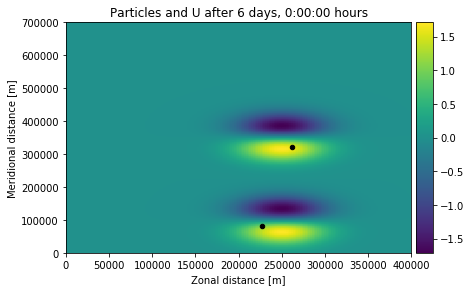

In [133]:
#print(pset)
pset.show(field=fieldset.U)

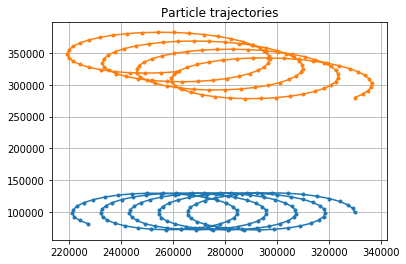

<module 'matplotlib.pyplot' from '/home/soundofives/programs/envs/py2_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [134]:
plotTrajectoriesFile('EddyParticles.nc')

In [2]:
plotTrajectoriesFile('EddyParticles.nc', mode='movie2d_notebook')

In addition to creating trajectory plots, you can also visualize the movement of the particles using a bin-based histogram.

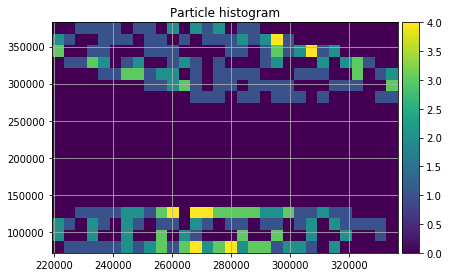

In [136]:
plotTrajectoriesFile('EddyParticles.nc', mode='hist2d', bins=[30, 20]);

## Adding Custom Behavior to Kernels

Let's say you want to model one of these particles as a motor boat that turns on its motor after some given time. You can add custom behavior to the kernels, such as giving the particles a velocity after a certain time.

In [137]:
def WestVel(particle, fieldset, time, dt):
    if time > 86400:
        uvel = -1.
        particle.lon += uvel * dt

After you define a function to match the behavior you want to give your particle, you can cast that function as a Parcels kernel and add it to the integrator within the execute command.

In [138]:
pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle, lon=[3.3e5, 3.3e5], lat=[1e5, 2.8e5])

k_WestVel = pset.Kernel(WestVel)        # casting the WestVel function to a kernel object

pset.execute(AdvectionRK4 + k_WestVel,  # simply add kernels using the + operator
             runtime=timedelta(days=2),
             dt=timedelta(minutes=5),
             output_file=pset.ParticleFile(name="EddyParticles_WestVel.nc", outputdt=timedelta(hours=1)))

INFO: Compiled JITParticleAdvectionRK4WestVel ==> /tmp/parcels-1000/0c89568ddbd6b6e533a9ed097b45929c.so


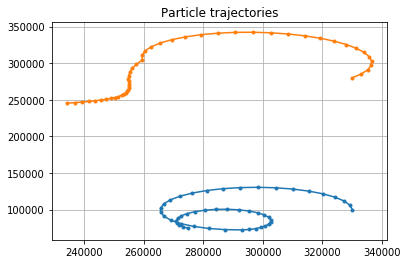

In [139]:
plotTrajectoriesFile('EddyParticles_WestVel.nc');

## Using Particles to Sample a Field

Parcels also allows you to customize the class of particle you are using, giving you the ability to create particles with various functionalities, such as sampling fields.

In [140]:
fieldset = FieldSet.from_parcels("Peninsula_data/peninsula",
                                 extra_fields={'P': 'P'}, allow_time_extrapolation=True)

As part of this, you have to create a new particle class--up until this point, we've been using the default JITparticle. Our new particle will have a variable to hold the pressure of the point in the field that it occupies.

In [141]:
class SampleParticle(JITParticle):         # Define a new particle class
    p = Variable('p', initial=fieldset.P)  # Variable 'p' initialised by sampling the pressure

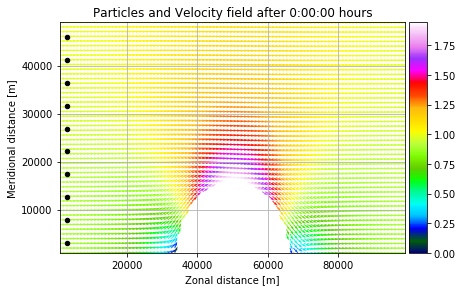

p values before execution: [-2.6537523, -6.900496, -11.19763, -15.565419, -20.013405, -24.541512, -29.142874, -33.806965, -38.522114, -43.27725]


In [142]:
pset = ParticleSet.from_line(fieldset=fieldset, pclass=SampleParticle, 
                             start=(3000, 3000), finish=(3000, 46000), size=10, time=0)
pset.show(field='vector')
print('p values before execution:', [p.p for p in pset])

Having made our custom particles, we now need a function to access that pressure variable. I create that below.

In [143]:
def SampleP(particle, fieldset, time, dt):  # Custom function that samples fieldset.P at particle location
    particle.p = fieldset.P[time, particle.lon, particle.lat, particle.depth]

k_sample = pset.Kernel(SampleP)    # Casting the SampleP function to a kernel.

INFO: Compiled SampleParticleAdvectionRK4SampleP ==> /tmp/parcels-1000/852dab730af52579255d232e5c2f25bf.so


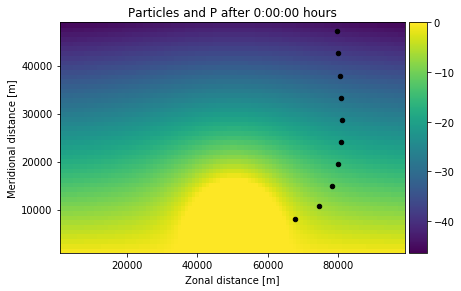

p values after execution: [-2.65027, -6.898519, -11.198785, -15.565077, -20.013111, -24.541224, -29.142294, -33.806847, -38.522133, -43.277206]


In [144]:
pset.execute(AdvectionRK4 + k_sample,    # Add kernels using the + operator.
             runtime=timedelta(hours=20),
             dt=timedelta(minutes=5),
            output_file=pset.ParticleFile(name="PeninsulaParticleTraj.nc", outputdt=timedelta(hours=1)))
pset.show(field=fieldset.P, show_time=0)
print('p values after execution:', [p.p for p in pset])

Now we can view the exact pressure that each particle is experiencing at any given point in time!

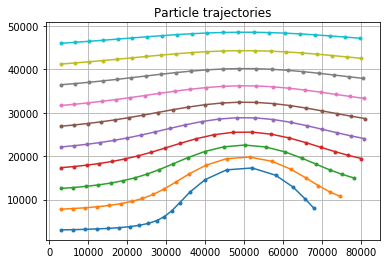

In [145]:
plotTrajectoriesFile('PeninsulaParticleTraj.nc');

In [3]:
plotTrajectoriesFile('PeninsulaParticleTraj.nc', mode='movie2d_notebook')

## Can you create your own vector fields?

All of what you've seen so far has been particles moving through vector fields created using experimental data downloaded from online databases. What if we wanted to create our own vector fields?

Lets say we have particles with arbitrary masses of 1 kg--how do they interact with a $$\frac{1}{r^2}$$ potential? Let's create a vector field to test this out.

## SMALL EXAMPLE

To create this vector field, I started with a blank matrix. At each node within the matrix, I calculated the $$\frac{1}{r^2}$$ potential using the center of the matrix as a reference. Mapping that onto the vector field components (the Ufield, or zonal component, and the Vfield, the meridional component), I was able to plot the field.

In [89]:
xdim, ydim= (200, 200)

M = 2 #kg
m = 1 #kg
scale = 1

#VECTORS!
#Baricenter vectors---------------------------------------------
baricenter = np.array([(xdim/2)*scale,(ydim/2)*scale])
print(baricenter)
Ufield = np.zeros((ydim,xdim))
Vfield = np.zeros((ydim,xdim))
for i in np.arange(ydim):
    for j in np.arange(xdim):
        planPos = np.array([i,j])
        
        rpb = planPos*scale - baricenter
        rpbhat = rpb/np.linalg.norm(rpb)
        rpbmag = np.sqrt(sum([x**2 for x in rpb]))
        if rpbmag != 0:
            Ufield[i][j] = -1/(rpbmag**2)*rpbhat[0]
            Vfield[i][j] = -1/(rpbmag**2)*rpbhat[1]
        else:
            Ufield[i][j] = 0
            Vfield[i][j] = 0
            
#print(Ufield)
#print(Vfield)

[100. 100.]


/home/soundofives/programs/envs/py2_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


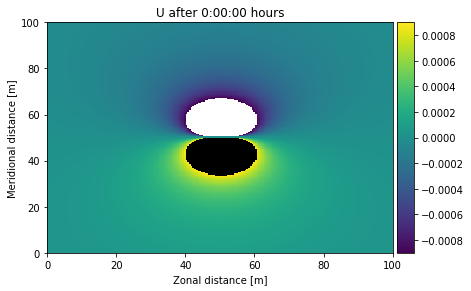

In [90]:
U = Field('U', Ufield,
          lon=np.linspace(0., 100, xdim, dtype=np.float32),
          lat=np.linspace(0., 100, ydim, dtype=np.float32))
V = Field('V', Vfield, grid=U.grid)
fieldset = FieldSet(U,V)

fieldset.U.show(vmax=9e-4,vmin = -9e-4)

Now we can create a few particle sets within the field and see how they react!

In [ ]:
pset = ParticleSet.from_line(fieldset=fieldset,
                             pclass=JITParticle, 
                             start=(70, 30), finish=(30, 70), size=10, time=0)

#print(pset)
pset.show(field=fieldset.U,vmax=9e-3,vmin = -9e-3)

In [92]:
print(pset)
#pset.show(field=fieldset.U,show_time=50)

P[341](lon=70.000000, lat=30.000000, depth=0.000000, time=0.000000)
P[342](lon=65.555557, lat=34.444443, depth=0.000000, time=0.000000)
P[343](lon=61.111111, lat=38.888889, depth=0.000000, time=0.000000)
P[344](lon=56.666668, lat=43.333332, depth=0.000000, time=0.000000)
P[345](lon=52.222221, lat=47.777779, depth=0.000000, time=0.000000)
P[346](lon=47.777779, lat=52.222221, depth=0.000000, time=0.000000)
P[347](lon=43.333332, lat=56.666668, depth=0.000000, time=0.000000)
P[348](lon=38.888889, lat=61.111111, depth=0.000000, time=0.000000)
P[349](lon=34.444443, lat=65.555557, depth=0.000000, time=0.000000)
P[350](lon=30.000000, lat=70.000000, depth=0.000000, time=0.000000)


In [93]:
pset.execute(AdvectionRK4, runtime=delta(hours=24), dt=delta(minutes=5),output_file=pset.ParticleFile(name="testforce2.nc", outputdt=timedelta(hours=0.5)))

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/aee1b73ce25c0405af8e7e5ae4bd38a1.so


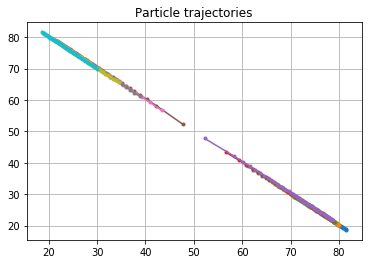

<module 'matplotlib.pyplot' from '/home/soundofives/programs/envs/py2_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [94]:
plotTrajectoriesFile('testforce2.nc')

In [4]:
plotTrajectoriesFile('testforce2.nc',mode='movie2d_notebook')

Now let's try a different orientation:

P[351](lon=70.000000, lat=90.000000, depth=0.000000, time=0.000000)
P[352](lon=70.000000, lat=87.586205, depth=0.000000, time=0.000000)
P[353](lon=70.000000, lat=85.172417, depth=0.000000, time=0.000000)
P[354](lon=70.000000, lat=82.758621, depth=0.000000, time=0.000000)
P[355](lon=70.000000, lat=80.344826, depth=0.000000, time=0.000000)
P[356](lon=70.000000, lat=77.931038, depth=0.000000, time=0.000000)
P[357](lon=70.000000, lat=75.517242, depth=0.000000, time=0.000000)
P[358](lon=70.000000, lat=73.103447, depth=0.000000, time=0.000000)
P[359](lon=70.000000, lat=70.689651, depth=0.000000, time=0.000000)
P[360](lon=70.000000, lat=68.275864, depth=0.000000, time=0.000000)
P[361](lon=70.000000, lat=65.862068, depth=0.000000, time=0.000000)
P[362](lon=70.000000, lat=63.448277, depth=0.000000, time=0.000000)
P[363](lon=70.000000, lat=61.034481, depth=0.000000, time=0.000000)
P[364](lon=70.000000, lat=58.620689, depth=0.000000, time=0.000000)
P[365](lon=70.000000, lat=56.206898, depth=0.000

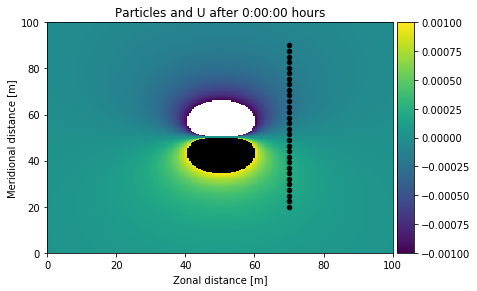

In [96]:
pset2 = ParticleSet.from_line(fieldset=fieldset,
                             pclass=JITParticle, 
                             start=(70, 90), finish=(70, 20), size=30, time=0)

print(pset2)
#pset.show(field=fieldset.U,domain=[100, 0, 100, 0],vmax=0.,vmin = -1e-2)
pset2.show(field=fieldset.U,vmax=1e-3,vmin = -1e-3)

In [97]:
pset2.execute(AdvectionRK4, runtime=delta(hours=24), dt=delta(minutes=1),output_file=pset.ParticleFile(name="testforce3.nc", outputdt=timedelta(hours=0.1)))

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/4a33f501b3e27de97ec0d277ad0d1bce.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


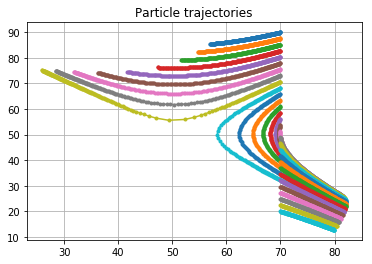

In [5]:
#print(pset2)
plotTrajectoriesFile('testforce3.nc')
plotTrajectoriesFile('testforce3.nc',mode='movie2d_notebook')

Let's expand this simulation by adding a second potential well! 

In [99]:
xdim, ydim= (200, 200)

M1 = 4 #kg
M2 = 0.5 #kg
m = 0.1 #kg
scale = 1

#VECTORS!
#Baricenter vectors---------------------------------------------
pot1 = np.array([(xdim/2)*scale,(ydim/2)*scale])
pot2 = np.array([(3*xdim/4)*scale,(3*ydim/4)*scale])
#print(baricenter)
Ufield = np.zeros((ydim,xdim))
Vfield = np.zeros((ydim,xdim))
for i in np.arange(ydim):
    for j in np.arange(xdim):
        planPos = np.array([i,j])
        
        rpb = planPos*scale - pot1
        rpp2 = planPos*scale - pot2
        
        rpbhat = rpb/np.linalg.norm(rpb)
        rpp2hat = rpp2/np.linalg.norm(rpp2)
        
        rpp2mag = np.sqrt(sum([x**2 for x in rpp2]))
        rpbmag = np.sqrt(sum([x**2 for x in rpb]))
        if rpbmag != 0 and rpp2mag != 0:
            Ufield[i][j] = (-(M1*m)/(rpbmag**2)*rpbhat[0])+(-(M2*m)/(rpp2mag**2)*rpp2hat[0])
            Vfield[i][j] = (-(M1*m)/(rpbmag**2)*rpbhat[1])+(-(M2*m)/(rpp2mag**2)*rpp2hat[1])
        else:
            Ufield[i][j] = 0
            Vfield[i][j] = 0
            
#print(Ufield)
#print(Vfield)

/home/soundofives/programs/envs/py2_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/soundofives/programs/envs/py2_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


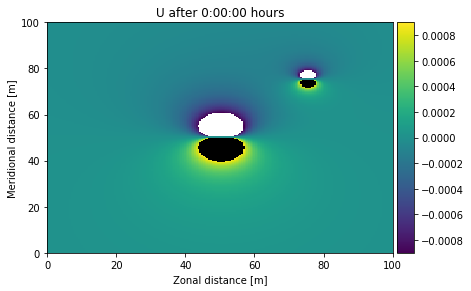

In [100]:
U = Field('U', Ufield,
          lon=np.linspace(0., 100, xdim, dtype=np.float32),
          lat=np.linspace(0., 100, ydim, dtype=np.float32))
V = Field('V', Vfield, grid=U.grid)
fieldset = FieldSet(U,V)

fieldset.U.show(vmax=9e-4,vmin = -9e-4)

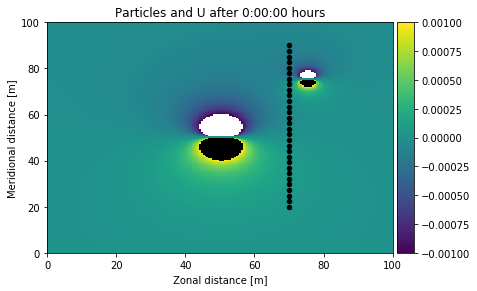

In [101]:
pset3 = ParticleSet.from_line(fieldset=fieldset,
                             pclass=JITParticle, 
                             start=(70, 90), finish=(70, 20), size=30, time=0)

#print(pset3)
#pset.show(field=fieldset.U,domain=[100, 0, 100, 0],vmax=0.,vmin = -1e-2)
pset3.show(field=fieldset.U,vmax=1e-3,vmin = -1e-3)

In [102]:
pset3.execute(AdvectionRK4, runtime=delta(hours=100), dt=delta(minutes=10),output_file=pset3.ParticleFile(name="testforce4.nc", outputdt=timedelta(hours=0.5)))

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/1c59ce2de47ce5a057c9211c10403ce6.so


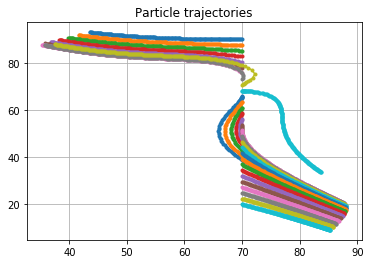

In [6]:
#print(pset2)
plotTrajectoriesFile('testforce4.nc')
plotTrajectoriesFile('testforce4.nc',mode='movie2d_notebook')

## Other Uses

Below are some tests I was doing to see if this module could recreate Brownian motion using a vector field of randomly generated velocities. The implimentation of this using the module gave rise to some unusual and difficult to fix errors, namely vague "Out of Bounds Sampling". 

In [2]:
import random as rand
for x in range(10):
  print(rand.randint(1,101))

81
82
85
2
6
50
94
70
59
21


In [73]:
xdim, ydim= (300, 300)

m = 1 #kg

#VECTORS!
#Baricenter vectors---------------------------------------------
#print(baricenter)
Ufield = np.zeros((ydim,xdim))
Vfield = np.zeros((ydim,xdim))
for i in np.arange(ydim):
    for j in np.arange(xdim):
        seed1 = rand.randint(-10,11)
        seed2 = rand.randint(-10,11)
        
        if(seed1 != 0):
            Ufield[i][j] = seed1
        else:
            Ufield[i][j] = 1
            
        if(seed2 != 0):
            Vfield[i][j] = seed2
        else:
            Vfield[i][j] = -1

In [74]:
def periodicBC(particle, fieldset, time, dt):
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west
    if particle.lat < fieldset.halo_north:
        particle.lat += fieldset.halo_south - fieldset.halo_north
    elif particle.lat > fieldset.halo_south:
        particle.lat -= fieldset.halo_south - fieldset.halo_north

In [81]:
U = Field('U', Ufield,
          lon=np.linspace(-5000., 5000, xdim, dtype=np.float32),
          lat=np.linspace(-5000., 5000, ydim, dtype=np.float32))
V = Field('V', Vfield, grid=U.grid)
fieldset = FieldSet(U,V)

#fieldset.U.show(vmax=50,vmin = -50)
#fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
#fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
#fieldset.add_constant('halo_north', fieldset.U.grid.lat[1])
#fieldset.add_constant('halo_south', fieldset.U.grid.lon[0])

#fieldset.add_periodic_halo(zonal=True)
#fieldset.add_periodic_halo(meridional=True)

P[280](lon=0.000000, lat=0.000000, depth=0.000000, time=0.000000)


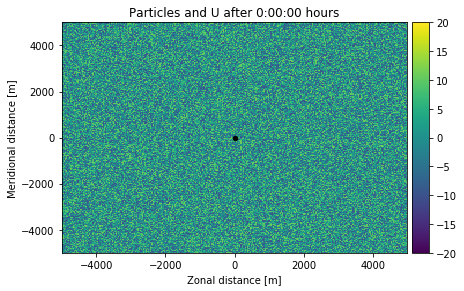

In [84]:
pset4 = ParticleSet.from_line(fieldset=fieldset,
                             pclass=JITParticle, 
                             start=(0, 0), finish=(50, 50), size=1, time=0)

print(pset4)
#pset.show(field=fieldset.U,domain=[100, 0, 100, 0],vmax=0.,vmin = -1e-2)
pset4.show(field=fieldset.U,vmax=20,vmin = -20)

In [83]:
pset4.execute(AdvectionRK4, runtime=delta(hours=24), dt=delta(minutes=1),output_file=pset4.ParticleFile(name="testBrownian2.nc", outputdt=timedelta(hours=0.1)))

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/17bdf2939c5db69d7837e12b07b145d2.so


OutOfBoundsError: 0
Particle P[279](lon=4829.081055, lat=2154.952148, depth=0.000000, time=8280.000000)
Time: 8280.0,	timestep dt: 60.000000
Out-of-bounds sampling by particle at (4829.081055, 2154.952148, 0.000000)

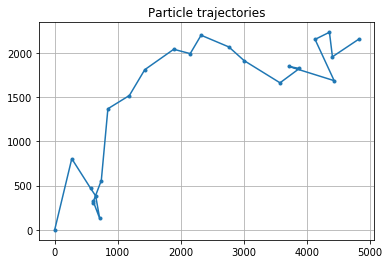

In [7]:
#print(pset2)
plotTrajectoriesFile('testBrownian2.nc')
plotTrajectoriesFile('testBrownian2.nc',mode='movie2d_notebook')

In summary, OceanParcels is a wonderful tool for any simulation that can be created using its main feature: vector fields and particle tracking. Applications like water currents, potential wells, and possibly Brownian motion (if errors can be avoided) and just a few possibilities.

The syntax can be tricky to get used to, and the errors can be difficult to interpret and fix, but in these simple applications it performs well.